In [2]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,weights,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

In [3]:
install.packages("remotes") 
remotes::install_github("YuLab-SMU/ggtree")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Using github PAT from envvar GITHUB_PAT

Skipping install of 'ggtree' from a github remote, the SHA1 (6bc28f39) has not changed since last install.
  Use `force = TRUE` to force installation



In [4]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

In [5]:
sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [6]:
for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

for (row_curr in c(1:nrow(for_plotting))) {
    if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
        extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
        if (length(extra_slots) == 11) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[5])
            for_plotting$Order[row_curr] = trimws(extra_slots[9])
            for_plotting$Family[row_curr] = trimws(extra_slots[10])
            for_plotting$Genus[row_curr] = trimws(extra_slots[11])
        } else if (length(extra_slots == 7)) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[3])
            for_plotting$Order[row_curr] = trimws(extra_slots[5])
            for_plotting$Family[row_curr] = trimws(extra_slots[6])
            for_plotting$Genus[row_curr] = trimws(extra_slots[7])
        }
        print(for_plotting[row_curr,])
    }
    if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
            for_plotting$Phylum[row_curr] = "Choanozoa"
            for_plotting$Class[row_curr] = "Ichthyosporea"
            for_plotting$Order[row_curr] = "Eccrinida"
            for_plotting$Family[row_curr] = "Piridae"
            for_plotting$Genus[row_curr] = "Pirum"
    }
    
    if (trimws(for_plotting$Phylum[row_curr]) == "Cryptophyceae") {
        for_plotting$Genus[row_curr] = for_plotting$Family[row_curr]
        for_plotting$Family[row_curr] = for_plotting$Order[row_curr]
        for_plotting$Order[row_curr] = for_plotting$Class[row_curr]
        for_plotting$Class[row_curr] = for_plotting$Phylum[row_curr]
        for_plotting$Phylum[row_curr] = "Cryptophyta"
    }
    
    if (trimws(for_plotting$Order[row_curr]) == "Fragilariophyceae") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    } else if (trimws(for_plotting$Class[row_curr]) == "Bacillariophyta") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    }
}
curr_cm="RF01960"

## information on when the climatological seasons occur
seasonal_info=read.csv("../../data/season_dates.csv",comment="#") %>%
    dplyr::mutate(StartDate=as.Date(StartDate,origin="1970-01-01",format="%Y-%m-%d"),
                  EndDate=as.Date(EndDate,origin="1970-01-01",format="%Y-%m-%d"))
get_season_from_date <- function(date_vect) {
    season_list = c()
    for (date_curr in date_vect) {
        selected_season = seasonal_info %>% dplyr::filter((StartDate <= date_curr)&(EndDate >= date_curr))
        if (length(selected_season)==0) {
            season_list = c(season_list,"Missing")
        } else {
            if (length(selected_season$Season) > 1) {
                print("YO what gives")
                print(selected_season$Season)
            }
            season_list = c(season_list,as.character(selected_season$Season))
        }
    }
    return(season_list)
}

means_within_seasons = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order)) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")) %>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate))

for_plotting_old_zscore = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

total_in_season = means_within_seasons %>% 
    dplyr::distinct(Season,Year,FormattedDate) %>%
    dplyr::group_by(Season,Year) %>%
    dplyr::tally()

means_with_seasons_ = means_within_seasons %>% 
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::group_by(Season,Label) %>%
    dplyr::summarize(meanTPM = sum(TPM*Weights) / sum(Weights),
                     sdTPM = sqrt((sum(((TPM-sum(TPM*Weights) / sum(Weights))^2)*Weights) / 
                          (sum(Weights)*(length(Weights)-1)/length(Weights)))))

curr_cm="RF01960"
for_plotting = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))%>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate)) %>%
    dplyr::left_join(means_with_seasons_,by=c("Season","Label")) %>%
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - meanTPM) / sdTPM) %>%
    dplyr::ungroup() %>% dplyr::select(-V1.x,-V1.y,-Superfamily.x,-Superfamily.y) %>%
    dplyr::filter(type.x=="S")

Joining, by = c("Year",
"Season")
`summarise()` has
grouped output by
'Season'. You can
override using the
`.groups` argument.
Joining, by = c("Year",
"Season")


In [7]:
t_test_2010 <- function(for_plotting, label, test = "ks", alternative="greater", thres_year = 2010) {
    pre_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year <= thres_year)
    post_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year > thres_year)
    if (test == "ks") {
        return(ks.test(pre_2010$TPM, post_2010$TPM))
    } else if (test == "t") {
        # if greater, pre-2010 is greater than post-2010. if less, pre-2010 is less than post-2010.
        return(t.test(pre_2010$TPM, post_2010$TPM,alternative=alternative))
    }
}

t_test_2010 <- function(for_plotting, label, weights="none",weightsy="non",
                        test = "ks", alternative="greater", thres_year = 2010) {
    pre_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year <= thres_year)
    post_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year > thres_year)
    if (test == "ks") {
        return(ks.test(pre_2010$TPM, post_2010$TPM))
    } else if (test == "t") {
        if (weights=="none"){
            weights=rep(1,length(pre_2010$TPM))
            weightsy=rep(1,length(post_2010$TPM))
        } else {
            weights=pre_2010$Weights
            weightsy=post_2010$Weights
        }
        # if greater, pre-2010 is greater than post-2010. if less, pre-2010 is less than post-2010.
        return(wtd.t.test(pre_2010$TPM, post_2010$TPM,
                          weight=weights,weighty=weightsy,alternative=alternative))
    }
}

categorize_vals = data.frame()
for_plot_tax = for_plotting %>% dplyr::distinct(Phylum,Order,Class,Genus,Family,Label)
for (curr_ind in c(1:nrow(for_plot_tax))) {
    curr = for_plot_tax$Label[curr_ind]
    curr_pval = t_test_2010(for_plotting, curr, test = "t", alternative="less", thres_year = 2010)$coefficients["p.value"]
    if (curr_pval <= 0.05) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="IncreasedPost2010")
    } else if (curr_pval >= 0.95) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="DecreasedPost2010")
    } else {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval, "Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="NoChange")
    }
    categorize_vals = categorize_vals %>% dplyr::bind_rows(curr_df)
}
categorize_vals$Verdict[p.adjust(categorize_vals$p.value, "BH") <= 0.05] = "IncreasedPost2010"
categorize_vals$Verdict[p.adjust(1-categorize_vals$p.value, "BH") <= 0.05] = "DecreasedPost2010"
categorize_vals$Verdict[(p.adjust(1-categorize_vals$p.value, "BH") > 0.05) &
                        (p.adjust(categorize_vals$p.value, "BH") > 0.05)] = "NoChange"

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

In [7]:
for_plotting %>%
    #dplyr::mutate(Season = sapply(as.Date(for_plotting$SampleDate,format="%d%b%Y"),getOurSeason)) %>%
    dplyr::mutate(Year = format(as.POSIXct(SampleDate,format="%d%b%Y"),"%Y")) %>%
    dplyr::select(Season,Phylum,Clade.y,SampleDate,X.rname,TPM,Year,Label,ZScore) %>%
    dplyr::left_join(categorize_vals %>% #dplyr::filter(Verdict == "IncreasedPost2010") %>% 
                     dplyr::select(Label,Verdict),
                    by="Label") %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata"))%>%
    dplyr::filter(Verdict =="IncreasedPost2010")

Season,Phylum,Clade.y,SampleDate,X.rname,TPM,Year,Label,ZScore,Verdict
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
Spring,Ciliophora,Alveolata,16May2013,Ga0334998_0026610SSU_rRNA_eukarya,46.83754,2013,MEND-TF-18S-29,-0.58159593,IncreasedPost2010
Spring,Alveolata,,16May2013,Ga0335002_0011433SSU_rRNA_eukarya,800.83628,2013,MEND-TF-18S-134,-0.64820325,IncreasedPost2010
Spring,Alveolata,,16May2013,Ga0334983_0007269SSU_rRNA_eukarya,7788.19158,2013,MEND-TF-18S-143,0.03842486,IncreasedPost2010
Spring,Alveolata,,16May2013,Ga0334986_0008194SSU_rRNA_eukarya,86.04250,2013,MEND-TF-18S-162,-0.85624439,IncreasedPost2010
Spring,Ciliophora,Alveolata,16May2013,Ga0334990_0005099SSU_rRNA_eukarya,5865.29476,2013,MEND-TF-18S-256,-0.20596809,IncreasedPost2010
Spring,Ciliophora,Alveolata,16May2013,Ga0453163_0005619SSU_rRNA_eukarya,11307.78182,2013,MEND-TF-18S-258,0.64907002,IncreasedPost2010
Spring,Ciliophora,Alveolata,16May2013,Ga0334991_0004876SSU_rRNA_eukarya,29.18400,2013,MEND-TF-18S-277,-0.14100753,IncreasedPost2010
Spring,Ciliophora,Alveolata,16May2013,Ga0334999_0030896SSU_rRNA_eukarya,730.01325,2013,MEND-TF-18S-281,-0.05225621,IncreasedPost2010
Spring,Ciliophora,Alveolata,16May2013,Ga0335004_0016403SSU_rRNA_eukarya,29.21707,2013,MEND-TF-18S-283,-0.52106961,IncreasedPost2010


In [8]:

make_euk_tree <- function(input_tree_file,input_tree_dict,cluster_all,chosen_layout="circular") {
  tree_file <- as.phylo(ggtree(input_tree_file,layout=chosen_layout))
  tree_plot <- as.data.frame(tree_file %>% fortify() %>%
                                   as_tibble()) 
  tree_plot <- tree_plot %>% dplyr::left_join(input_tree_dict,by=c("label"="Labels"))%>% 
        dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
        dplyr::filter((type == "S") | (is.na(type)))
  
  unique_phyla = unique(input_tree_dict$Phylum)
  unique_phyla = unique_phyla[unique_phyla != ""]
  # change this line
  tip_colors <- lapply(unique_phyla, function(x)
  {tree_plot$label[grepl(paste(x, collapse="|"),
                             tree_plot$Phylum)]})
  names(tip_colors) <- unique_phyla
  tip_colors <- Filter(function(x) length(x) > 0, tip_colors)
  #tree_file_to_plot <- as(tree_plot,"phylo") 
  for_input = drop.tip(ape::root(as.phylo(ggtree(tree_plot)), node = 86),
                tip=extract.clade(alveolate_tree,node=107)$tip.label[-1],subtree=FALSE)
  tree_to_plot <- groupOTU(for_input, tip_colors,
                              overlap="overwrite")
                       
  data_tree <- as.data.frame(ggtree(tree_to_plot)$data) %>%
        dplyr::left_join(input_tree_dict,by=c("label"="Labels"))%>% 
        dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
        dplyr::filter((type == "S") | (is.na(type)))
  data_tree = data_tree %>%
      dplyr::mutate(Metagenome = dplyr::case_when(grepl("rRNA",label) ~ "MG",
                                                  TRUE ~ "Ref")) %>%
      dplyr::mutate(Label = dplyr::case_when(Label == Label ~ Label,
                                      TRUE ~ "Ref"),
                    type = dplyr::case_when(Metagenome != "Ref" ~ type,
                                      TRUE ~ "S")) %>%
      dplyr::filter(type == "S")
  data_tree = data_tree %>%
    #dplyr::left_join(input_tree_dict,by=c("label"="Labels")) %>%
    dplyr::mutate(Metagenome = 
                    dplyr::case_when(Metagenome  == "Ref" ~ "Ref",
                                     Metagenome == "MG" ~ "MG",
                                     TRUE ~ "None"))
  return(data_tree)
}


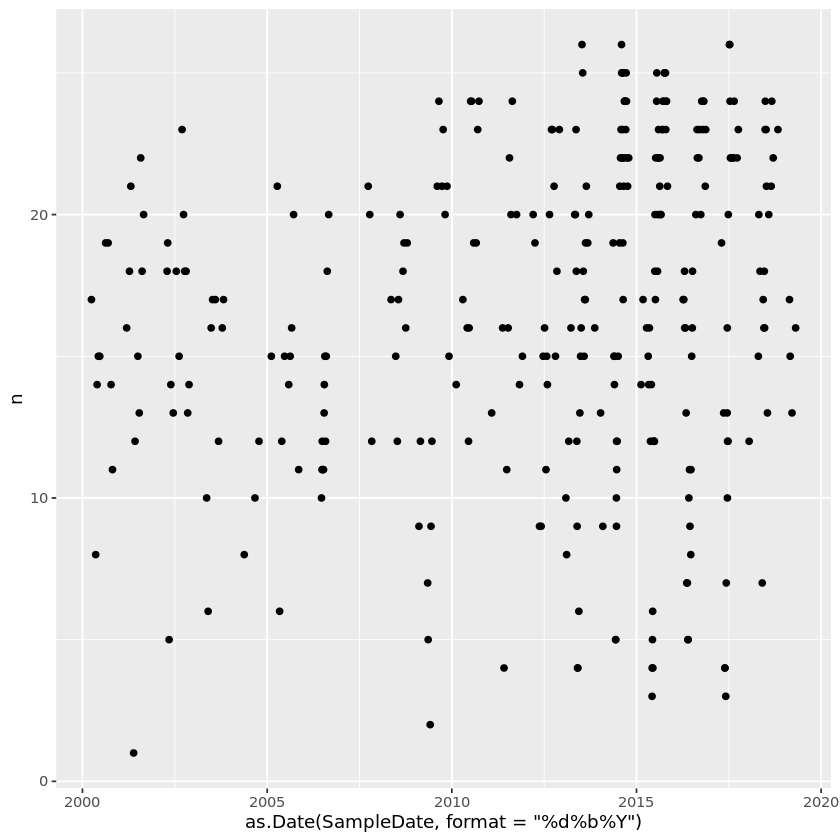

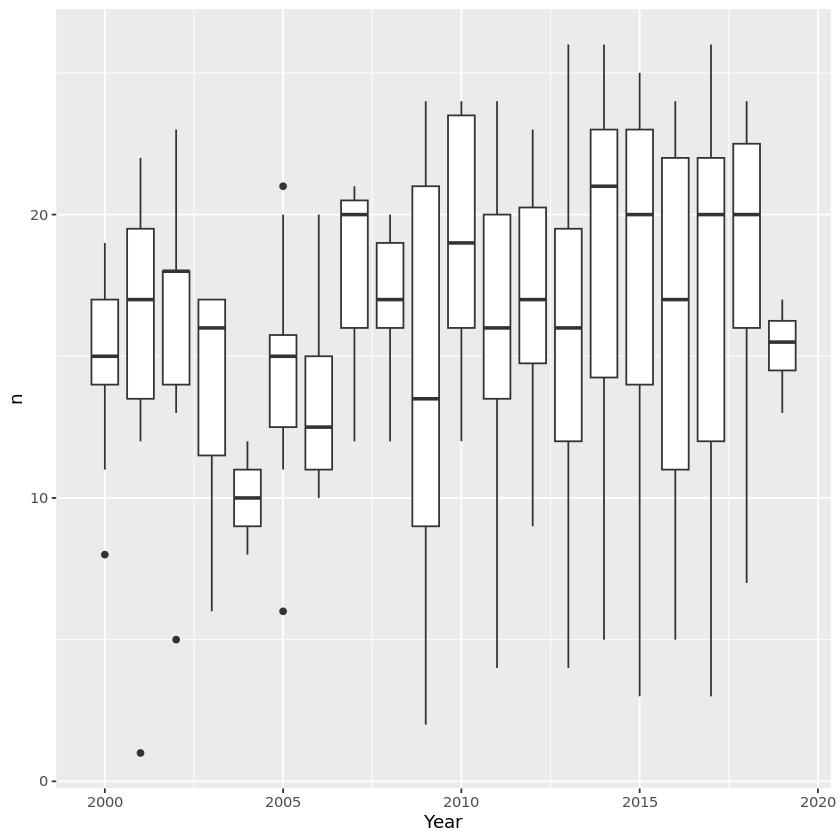

Warning message:
“Removed 99 rows
containing non-finite
values
(`stat_boxplot()`).”


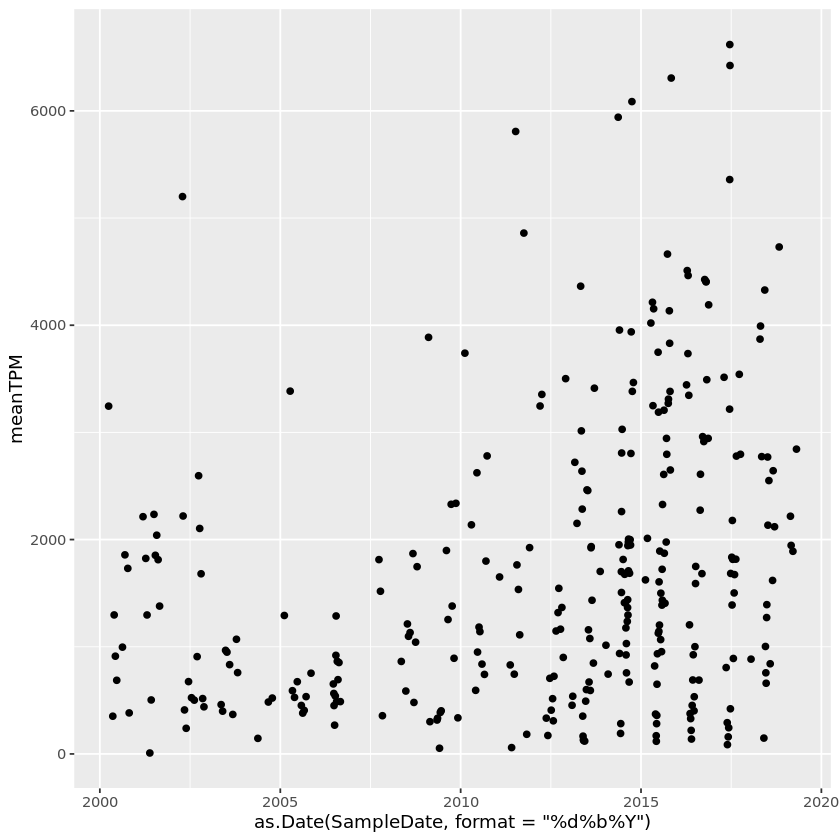

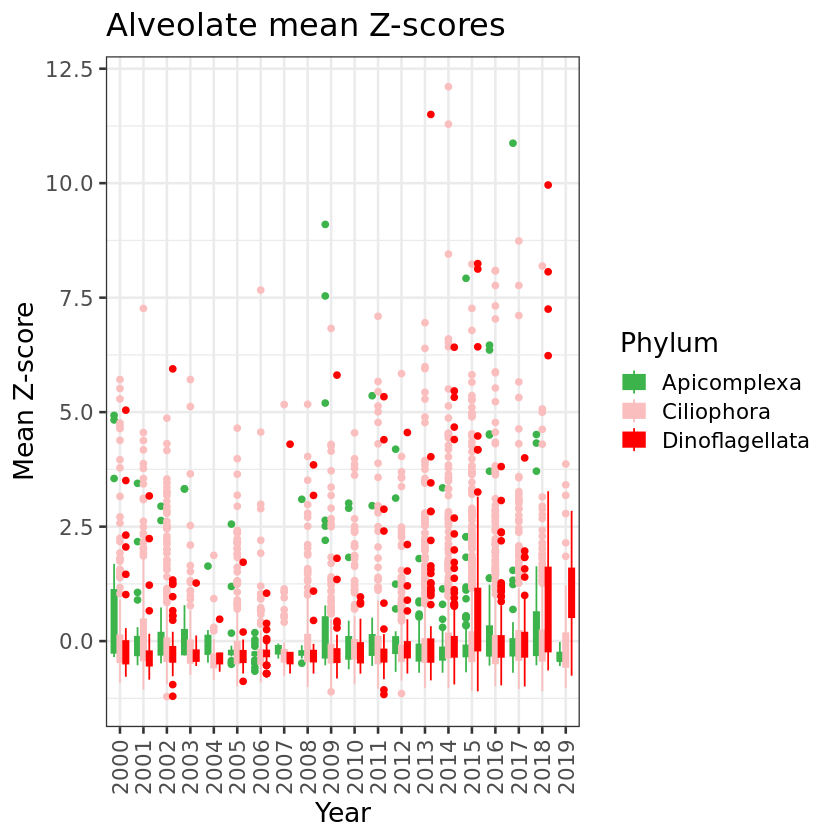

In [9]:
count_alveolates = for_plotting %>% dplyr::filter(TPM > 100) %>% 
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata"))%>%
    dplyr::distinct(Genus,Family,Class,Order,SampleDate,.keep_all=TRUE) %>%
    dplyr::group_by(SampleDate) %>% dplyr::tally()
ggplot(count_alveolates) + geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"),
                                        y = n))

count_alveolates = for_plotting %>% dplyr::filter(TPM > 100) %>% 
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::distinct(Genus,Family,Class,Order,SampleDate,.keep_all=TRUE) %>%
    dplyr::group_by(Year,SampleDate) %>% dplyr::tally()
ggplot(count_alveolates) + geom_boxplot(aes(x = Year,
                                        y = n,group=Year))


count_alveolates = for_plotting %>% 
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::distinct(Genus,Family,Class,Order,SampleDate,.keep_all=TRUE) %>%
    dplyr::group_by(SampleDate) %>% dplyr::summarize(meanTPM = mean(TPM))
ggplot(count_alveolates) + geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"),
                                        y = meanTPM))

count_alveolates = for_plotting %>% 
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_alveolate", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    dplyr::distinct(Genus,Phylum,Family,Class,Order,SampleDate,.keep_all=TRUE) %>%
    dplyr::group_by(SampleDate,Year,Phylum) %>%
    #dplyr::summarize(meanZScore = mean(ZScore),sdZScore = sd(ZScore)) %>%
    dplyr::filter(!is.na(Year))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))
distinct_phyla <- c(sort(c(unique(data_tree_euk$Phylum),c("Bacterial"))),"Dinoflagellata")
phylum_distinct_cols <- c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', 'gray', '#911eb4', 
                   '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                   '#9a6324', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#000075', '#808080',"red")#, '#ffffff', '#000000')

alveolate_boxplot = ggplot(count_alveolates) + geom_boxplot(aes(x = factor(Year),
                                        y = ZScore,fill=Phylum,color=Phylum)) + #,outlier.shape = NA) + 
    theme_bw(base_size=16) +
    ylab("Mean Z-score") + #scale_fill_manual(values=c("turquoise","pink","red","green")) +
    #scale_color_manual(values=c("turquoise","pink","red","green")) +
    scale_fill_manual(values=phylum_distinct_cols,breaks=distinct_phyla,name="Phylum") +
    scale_color_manual(values=phylum_distinct_cols,breaks=distinct_phyla,name="Phylum") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("Year") +
    ggtitle("Alveolate mean Z-scores") #+ ylim(c(-0.2,5))#+ theme(legend.position="none")
alveolate_boxplot

In [10]:
selected_increased %>% 
    dplyr::distinct(Phylum,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Clade.y","Label"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Year"),names_from="high_Z",values_from="n")

ERROR: Error in dplyr::distinct(., Phylum, Label, SampleDate, Clade.y, .keep_all = TRUE): object 'selected_increased' not found


In [ ]:
selected_increased = for_plotting %>%
    #dplyr::mutate(Season = sapply(as.Date(for_plotting$SampleDate,format="%d%b%Y"),getOurSeason)) %>%
    dplyr::mutate(Year = format(as.POSIXct(SampleDate,format="%d%b%Y"),"%Y")) %>%
    dplyr::select(Season,Phylum,Clade.y,SampleDate,X.rname,TPM,Year,Label,ZScore) %>%
    dplyr::left_join(categorize_vals %>% #dplyr::filter(Verdict == "IncreasedPost2010") %>% 
                     dplyr::select(Label,Verdict),
                    by="Label") %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata"))%>%
    dplyr::filter(Verdict =="IncreasedPost2010")

alv_dist = ggplot(selected_increased %>% 
    dplyr::distinct(Phylum,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Clade.y","Label"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,high_Z,SampleDate) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Year","SampleDate"),names_from="high_Z",values_from="n")) + 
    geom_boxplot(aes(x=factor(Year),y=Present/(Present+Absent),
                     group=paste0(Phylum,Year),fill=Phylum))+#,position="identity",stat="identity",alpha=0.5)+
    scale_fill_manual(values=c("#785EF0","#DC267F","#FE6100"),
                      breaks=c("Ciliophora","Apicomplexa","Dinoflagellata"),
                      name="Phylum")+theme_bw(base_size=16)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ylab("Year") +
    xlab("Proportion of days with positive Z-score")#+#facet_wrap(~Phylum)+
    #geom_vline(aes(xintercept=0.25),linetype="dotdash")
alv_dist

In [ ]:
selected_increased = for_plotting %>%
    #dplyr::mutate(Season = sapply(as.Date(for_plotting$SampleDate,format="%d%b%Y"),getOurSeason)) %>%
    dplyr::mutate(Year = format(as.POSIXct(SampleDate,format="%d%b%Y"),"%Y")) %>%
    dplyr::select(Season,Phylum,Clade.y,SampleDate,X.rname,TPM,Year,Label,ZScore) %>%
    dplyr::left_join(categorize_vals %>% #dplyr::filter(Verdict == "IncreasedPost2010") %>% 
                     dplyr::select(Label,Verdict),
                    by="Label") %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata"))%>%
    dplyr::filter(Verdict =="IncreasedPost2010")

alv_dist = ggplot(selected_increased %>% 
    dplyr::distinct(Phylum,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Clade.y","Label"),
                       names_from="SampleDate",
                       values_from="ZScore") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y",
                                            "Label")),names_to="SampleDate",values_to="ZScore") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    replace_na(list(ZScore=0)) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when(ZScore > 0~"HighZ",
                                     TRUE ~"LowZ")) %>% 
    dplyr::group_by(Phylum,Year,high_Z,Label) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Label","Year"),
                       names_from="high_Z",values_from="n") %>%
    replace_na(list(HighZ=0,LowZ=0)) %>%
    dplyr::mutate(fractHighVals=HighZ/(HighZ+LowZ))) + 
    geom_density_ridges(aes(y=factor(Year),x=fractHighVals,
                            group=paste0(Phylum,Year),fill=Phylum),alpha=0.5,pch=21)+
    scale_fill_manual(values=c("#785EF0","#DC267F","#FE6100"),
                      breaks=c("Ciliophora","Apicomplexa","Dinoflagellata"),
                      name="Phylum")+theme_bw(base_size=16)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ylab("Year") +
    xlab("Proportion of days with positive Z-score")+#facet_wrap(~Phylum)+
    geom_vline(aes(xintercept=0.25),linetype="dotdash")
alv_dist

In [16]:
bar_data=for_plotting %>% 
    tidyr::pivot_wider(id_cols=c("Phylum"),
                       names_from="SampleDate",
                       values_from="ZScore") %>%
    tidyr::pivot_longer(cols=!starts_with("Phylum"),names_to="SampleDate",values_to="ZScore") %>%
    replace_na(list(ZScore=0)) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when(ZScore > 1~"HighZ",
                                     TRUE ~"LowZ")) %>% 
    dplyr::group_by(Phylum,Year,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum))
ggplot() +
    geom_bar(data=bar_data%>%dplyr::filter(Phylum=="Ciliophora"),
             aes(x = Year, y = n, fill =factor(Phylum,levels=c("Ciliophora",
                                                               "Apicomplexa",
                                                               "Alveolata")),
                 group=factor(Phylum,levels=c("Ciliophora","Apicomplexa","Dinoflagellata"))),
             stat="identity",position="identity",
             alpha=1) +
    geom_bar(data=bar_data%>%dplyr::filter(Phylum=="Dinoflagellata"),
             aes(x = Year, y = n, fill =factor(Phylum,levels=c("Ciliophora",
                                                               "Apicomplexa",
                                                               "Dinoflagellata")),
                 group=factor(Phylum,levels=c("Ciliophora","Apicomplexa","Dinoflagellata"))),
             stat="identity",position="identity",
             alpha=1)+
    geom_bar(data=bar_data%>%dplyr::filter(Phylum=="Apicomplexa"),
             aes(x = Year, y = n, fill =factor(Phylum,levels=c("Ciliophora",
                                                               "Apicomplexa",
                                                               "Alveolata")),
                 group=factor(Phylum,levels=c("Ciliophora","Apicomplexa","Dinoflagellata"))),
             stat="identity",position="identity",
             alpha=0.5)+
    scale_fill_manual(values=phylum_distinct_cols,
                      breaks=c("Ciliophora","Apicomplexa","Dinoflagellata"),
                      name="Phylum")+theme_bw(base_size=16)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("Year") +
    ylab("Number of days with Z-score > 1")
      #aes(y = Year, x = ZScore,fill=Phylum,group=Phylum))+
    #geom_density_ridges(aes(y = Year, x = ZScore,fill=Phylum,group=paste0(Year,Phylum)),color="black")

Warning message:
“Values from `ZScore` are not uniquely identified; output will contain list-cols.
* Use `values_fn = list` to suppress this warning.
* Use `values_fn = {summary_fun}` to summarise duplicates.
* Use the following dplyr code to identify duplicates.
  {data} %>%
    dplyr::group_by(Phylum, SampleDate) %>%
    dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
    dplyr::filter(n > 1L)”


ERROR: [1m[33mError[39m in `vec_assign()`:[22m
[33m![39m Can't convert `replace$ZScore` <double> to match type of `data$ZScore` <list>.


In [ ]:
ggplot(count_alveolates) + geom_boxplot(aes(x = factor(Year),
                                        y = ZScore,fill=Phylum,color=Phylum)) + #,outlier.shape = NA) + 
    theme_bw(base_size=16) +
    ylab("Mean Z-score") + #scale_fill_manual(values=c("turquoise","pink","red","green")) +
    #scale_color_manual(values=c("turquoise","pink","red","green")) +
    scale_fill_manual(values=phylum_distinct_cols,breaks=distinct_phyla,name="Phylum") +
    scale_color_manual(values=phylum_distinct_cols,breaks=distinct_phyla,name="Phylum") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("Year") +
    ggtitle("Alveolate mean Z-scores")

In [ ]:
count_alveolates = for_plotting %>% 
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::distinct(Genus,Family,Class,SampleDate,.keep_all=TRUE) %>%
    dplyr::mutate(TPMCat = dplyr::case_when(TPM > 500 ~ "Present",
                                  TPM < 500 ~ "Absent")) %>%
    dplyr::group_by(Year,SampleDate,Class,TPMCat) %>% 
    dplyr::tally() %>%
    tidyr::pivot_wider(id_cols = c(Year,SampleDate,Class), names_from = TPMCat, values_from = n) %>%
    tidyr::replace_na(list(Absent=0,Present=0)) %>%
    dplyr::mutate(ProportionOccurrences = Present/(Present+Absent))
alveolate_distinct = ggplot(count_alveolates) + geom_boxplot(aes(x = factor(Year), y = ProportionOccurrences,
                                                             fill = Class))+
    #scale_fill_manual(values=c("turquoise","pink","red","green")) + 
    facet_wrap(~Class) + 
    theme_bw(base_size=16) + 
    ggtitle("Number of distinct orders")
alveolate_distinct

`summarise()` has
grouped output by
'Year'. You can override
using the `.groups`
argument.
Warning message:
“Using `size` aesthetic
for lines was deprecated
in ggplot2 3.4.0.
ℹ Please use `linewidth`
  instead.”


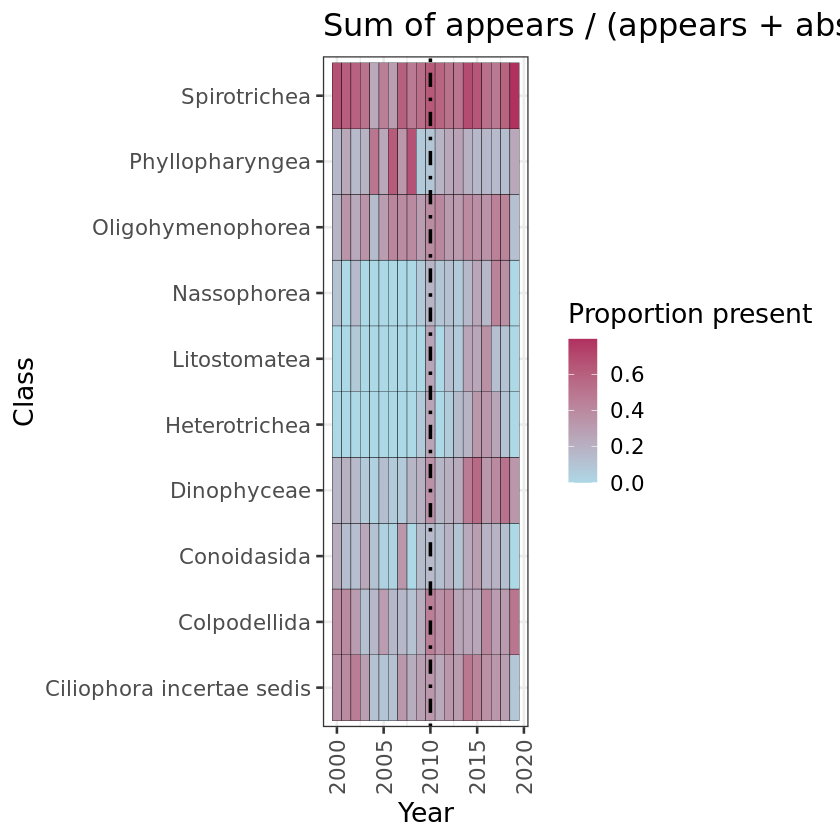

In [18]:
count_alveolates = for_plotting %>% dplyr::filter((trimws(Phylum) == "Alveolata")|
                                                  (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_alveolate",
                                        paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::distinct(Genus,Family,Order,Class,Label,SampleDate,.keep_all=TRUE) %>%
    dplyr::mutate(TPMCat = dplyr::case_when(TPM > 500 ~ "Present",
                                  TPM < 500 ~ "Absent")) %>%
    dplyr::group_by(Year,SampleDate,Family,Order,Label,Class,TPMCat) %>% 
    dplyr::tally() %>%
    tidyr::pivot_wider(id_cols = c(Year,SampleDate,Order,Class,Family,Label), names_from = TPMCat, values_from = n) %>%
    tidyr::replace_na(list(Absent=0,Present=0)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Year,Class) %>%
    dplyr::summarize(Present = sum(Present), Absent = sum(Absent)) %>%
    dplyr::mutate(ProportionOccurrences = Present / (Present + Absent))
    #dplyr::mutate(ProportionOccurrences = Present/(Present+Absent))

alveolate_heatmap = ggplot(count_alveolates) + 
    geom_tile(aes(x = Year, y = Class, fill = ProportionOccurrences),col="black") + 
    #geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"), y = ProportionOccurrences, 
    #               fill = Family, size = Year),
    #           pch=21,alpha=0.5) + 
    #geom_line(aes(x = as.Date(SampleDate,format="%d%b%Y"), y = ProportionOccurrences,
    #              group = Family)) + 
#geom_bar(aes(x = as.Date(SampleDate,format="%d%b%Y"), 
#                                                             y = Present,
#                                                             fill = Class),stat="identity")+
    theme_bw(base_size=16) + #theme(legend.position="none") +
    scale_fill_gradient(low = "light blue", high = "maroon", name = "Proportion present") + 
    geom_vline(aes(xintercept=2010),size=1,linetype="dotdash") + 
    scale_size(name="Year") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("Year") +
    ggtitle("Sum of appears / (appears + absent) ")
alveolate_heatmap

## Alveolate tree

In [11]:
folder_stub = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                        "refseq-DIAMOND", "tree-builder", "2021-12-20_alveolate")

In [12]:
alveolate_tree <- read.tree(file.path(folder_stub,"iqtree_select",
                                     "total_tree_RF01960.treefile"))

In [13]:
alveolate_tree <- read.tree(file.path(folder_stub,"iqtree_select",
                                     "total_tree_RF01960.treefile"))
rooted.tree.alv <- ape::root(alveolate_tree, node = 86)
rooted.tree.alv <- alveolate_tree

split_labs = c()
for (curr_lab in alveolate_tree$tip.label) {
    if (grepl("\\|", curr_lab)) {
        split_labs = c(split_labs,unlist(strsplit(unlist(strsplit(curr_lab, "\\|"))[2],"\\."))[1])
    } else {
        split_labs = c(split_labs,unlist(strsplit(unlist(strsplit(curr_lab, "\\|"))[1],"\\."))[1])
    }
}
alveolate_tree$tip.label = split_labs

In [14]:
# Filter the output by the OTUs that have more than 10 entries across 
# the samples (clustered at 97%)
cluster_files = c(paste0("meta-lakes/2021-06-11_treebuilder/clustered_contigs/", 
                 "reference.RF01960.clusters"),
                 paste0("meta-lakes/2021-06-11_treebuilder/clustered_contigs/", 
                 "reference.RF00177.clusters"))
cluster_files = c("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S/refseq-DIAMOND/2021-11-07_treebuilder/clustered_contigs/reference.RF01960.clusters",
                  "/vortexfs1/omics/alexander/akrinos/2021-mendota-18S/refseq-DIAMOND/2021-11-07_treebuilder/clustered_contigs/reference.RF00177.clusters")
cluster_all = data.frame()
for (cluster_file in cluster_files) {
    clust_f = read.csv(cluster_file,sep="\t",header=FALSE)
    colnames(clust_f)=c("type","clustnum","seqlen",
                        "percid","plus","a","b",
                        "aln","query","target")
    if (grepl("RF01960",cluster_file)) {
        clust_f["clustnum"] = -1*(as.numeric(clust_f$clustnum) + 1)
    }
    clust_f["Label"] = 0
    for (curr in 1:nrow(clust_f)) {
        if (clust_f$clustnum[curr] < 0) {
            clust_f[curr,"Label"] = paste0("MEND-TF-18S-",as.character(abs(clust_f[curr,"clustnum"])))
        } else {
            clust_f[curr,"Label"] = paste0("MEND-TF-16S-",as.character(abs(clust_f[curr,"clustnum"])))
        }
    }
    cluster_all = cluster_all %>% dplyr::bind_rows(clust_f)
}

In [15]:
tree_file_alv_mod = alveolate_tree

folder_stub = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                        "refseq-DIAMOND", "tree-builder", "2021-12-20_alveolate")
#data_tree_alv_mod <- make_data_tree_euk(tree_file_alv_mod, folder_stub_curr = folder_stub, #
#                              file_tax ="taxonomy_dict_RF01960.csv", layout = "circular")
curr_cm = "RF01960"
data_tree_alv_mod = make_euk_tree(tree_file_alv_mod,read.csv(file.path(folder_stub,
                                                                        paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),chosen_layout="circular",cluster_all=cluster_all)

data_tree_alv_mod$Phylum[((data_tree_alv_mod$isTip) & is.na(data_tree_alv_mod$Phylum)) | 
                         (grepl("Ochrophyta",data_tree_alv_mod$Phylum)) ] = "Ochrophyta"
data_tree_alv_mod = data_tree_alv_mod %>% dplyr::mutate(x = dplyr::case_when(x > 4 ~ x - 4,
                                                            TRUE ~ x))
data_tree_alv_mod$Metagenome[data_tree_alv_mod$Phylum == "Ochrophyta"] = "Outgroup"

In [16]:
barplot_df = data_tree_alv_mod %>%
    dplyr::left_join(cluster_all %>% dplyr::group_by(target) %>% 
                      dplyr::distinct(query,target) %>% 
    dplyr::tally() ,by=c("label"="target")) %>%
    dplyr::select(n,label,Class,y) %>%
    dplyr::filter(!is.na(label)) %>%
    dplyr::rename("id"="label","val"="n")

In [25]:
na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class))

[1] "Dinophyceae"               "Colpodellida"             
 [3] "Conoidasida"               "Ciliophora incertae sedis"
 [5] "Phyllopharyngea"           "Heterotrichea"            
 [7] "Spirotrichea"              "Litostomatea"             
 [9] "Nassophorea"               "Oligohymenophorea"        
[11] "Fragilariophyceae"        
attr(,"na.action")
[1] 12
attr(,"class")
[1] "omit"

In [18]:
families_list = na.omit(unique((data_tree_alv_mod %>% dplyr::filter(Phylum != "Ochrophyta"))$Class))
alv_cols = c('#f16913',"#ff4c00","red",#"#FE6100","#DC267F","pink",
             '#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b')
hilight_frame = data.frame()
for (curr_fam in families_list) {
    hilight_frame = hilight_frame %>%
        dplyr::bind_rows(data.frame("Nodes" = ggtree::MRCA(as.phylo(ggtree(data_tree_alv_mod)), 
                                              (data_tree_alv_mod %>% dplyr::filter(grepl(curr_fam,Class)))$label),
               "Labels" = c(curr_fam)))
}
distinct_cols=c("#c74eaf","#52bc60","#9c5bca","#90b53d","#656fc5",
                "#cea947","#5ba5d7","#d0463f","#52b598","#d2457f","#54823f",
                "#c683bf","#8b7535","#b9606e","#cb753f")
#ggtree(data_tree_alv_mod) + #geom_tiplab(aes(label=Class)) + 
p1<-ggplot(data_tree_alv_mod,aes(x=x,y=y)) + #%>% collapse(node=107) +
    #geom_hilight(data=hilight_frame, aes(node= Nodes, fill = Labels),extend=0.3,alpha=0.25) + #, extendto=2) + 
    geom_tree(layout="roundrect") +
    geom_point2(aes(subset=(node==23)), shape=21, size=5, fill='grey') + 
    geom_tippoint(data=data_tree_alv_mod, #%>% dplyr::filter(Metagenome == "MG"),
                  aes(shape=Metagenome,fill=Class,size=Metagenome),color="black") + 
    scale_color_manual(values = alv_cols, 
                      breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black")+ 
    scale_fill_manual(values = alv_cols, 
                      breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black", name = "Class group") +
    scale_size_manual(breaks=c("MG","Ref","Outgroup"),values=c(3,1,0.25))+
    scale_shape_manual(breaks=c("MG","Ref","Outgroup"),values=c(21,22,23)) + 
    ylim(c(min(data_tree_alv_mod$y),max(data_tree_alv_mod$y)))+ 
    theme_void(base_size=16)+
    guides(fill = guide_legend(override.aes = list(pch=21,size=4)))
    
    #+
    #geom_fruit(
    #          data=barplot_df,
    #          geom=geom_barh,
    #          mapping=aes(x = val, y=y, 
    #                      fill=Class),
    #          color = "grey50", stat = "identity"
    #      )

#ggtree::facet_plot(p1,panel="number extracted sequences", data=barplot_df,
#           geom=geom_barh, mapping=aes(x=as.numeric(val),fill=Class),stat="identity")

Joining, by = "Label"
Scale for y is already
present.
Adding another scale for
y, which will replace
the existing scale.


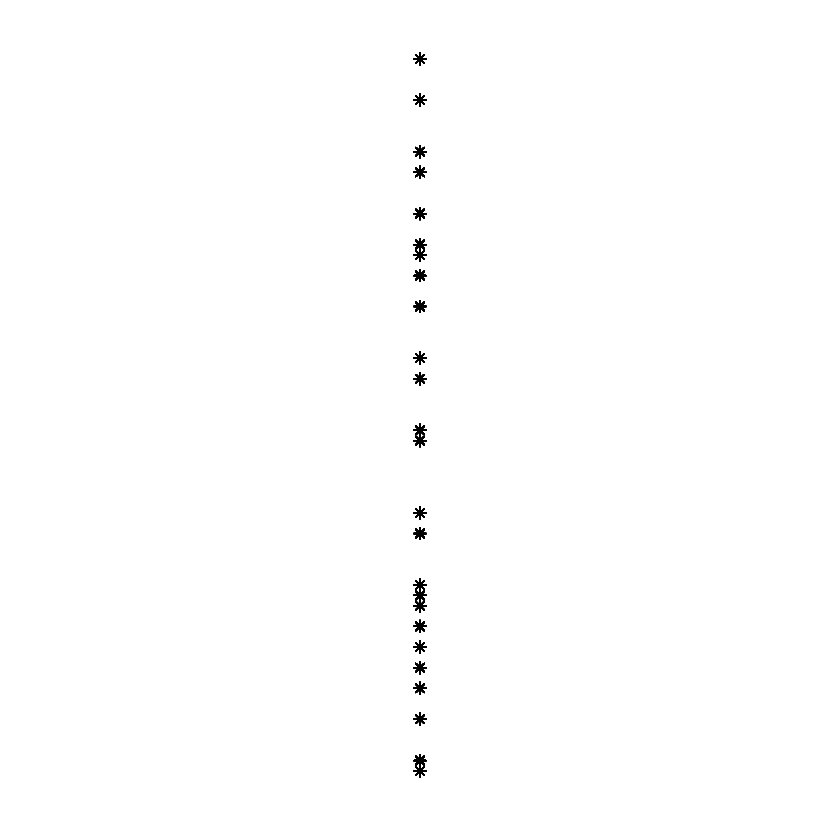

In [19]:
verdict_plot = ggplot(for_plotting %>% 
    dplyr::select(-y)%>%dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>%
    #dplyr::mutate(Season = sapply(as.Date(for_plotting$SampleDate,format="%d%b%Y"),getOurSeason)) %>%
    dplyr::mutate(Year = format(as.POSIXct(SampleDate,format="%d%b%Y"),"%Y")) %>%
    dplyr::select(Season,Phylum,Clade.y,SampleDate,X.rname,TPM,Year,Label,ZScore,y) %>%
    dplyr::left_join(categorize_vals %>% #dplyr::filter(Verdict == "IncreasedPost2010") %>% 
                     dplyr::select(Label,Verdict),
                    by="Label") %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata"))%>%
    dplyr::filter(Verdict =="IncreasedPost2010") %>% 
    dplyr::mutate(color_pt = dplyr::case_when(Verdict == "IncreasedPost2010" ~ "true",
                                         TRUE ~ "none"))) + 
    geom_point(aes(y = y, x = 0, color = color_pt),pch=8,size=2) + theme_void(base_size=16) + xlim(-0.5,0.5) + 
    scale_color_manual(breaks=c("true","none"), values = c("black","transparent")) + 
    theme(legend.position="none") + aplot::ylim2(p1) + 
    ylim(c(min(data_tree_alv_mod$y),max(data_tree_alv_mod$y)))
verdict_plot

Joining, by = "Label"


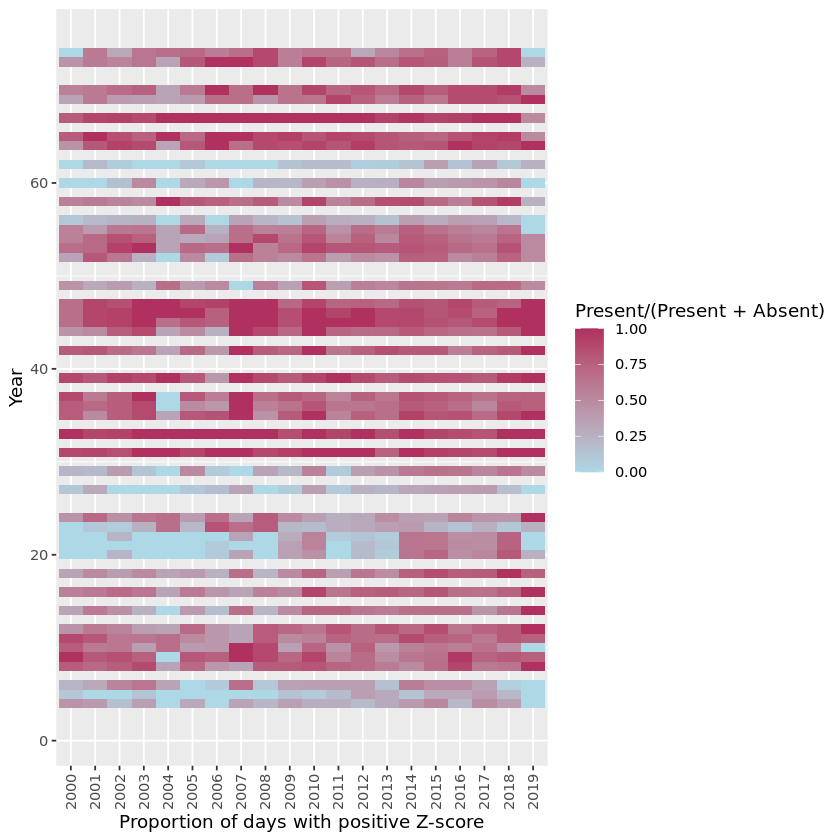

In [20]:
heatplot = ggplot(for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Class,high_Z,y) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Year","y"),names_from="high_Z",values_from="n")%>%
    replace_na(list(Present=0,Absent=0))) + 
    geom_tile(aes(x=factor(Year),fill=Present/(Present+Absent),y=y,
                     group=paste0(Phylum,Year)))+#,position="identity",stat="identity",alpha=0.5)+
    #scale_fill_manual(values=c("#785EF0","#DC267F","#FE6100"),
    #                  breaks=c("Ciliophora","Apicomplexa","Dinoflagellata"),
    #                  name="Phylum")+theme_bw(base_size=16)+
    scale_fill_gradient(low="light blue",high="maroon") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    ylab("Year") +
    xlab("Proportion of days with positive Z-score")+ 
    ylim(c(min(data_tree_alv_mod$y),max(data_tree_alv_mod$y)))
heatplot

Joining, by = "Label"
`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'
`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'


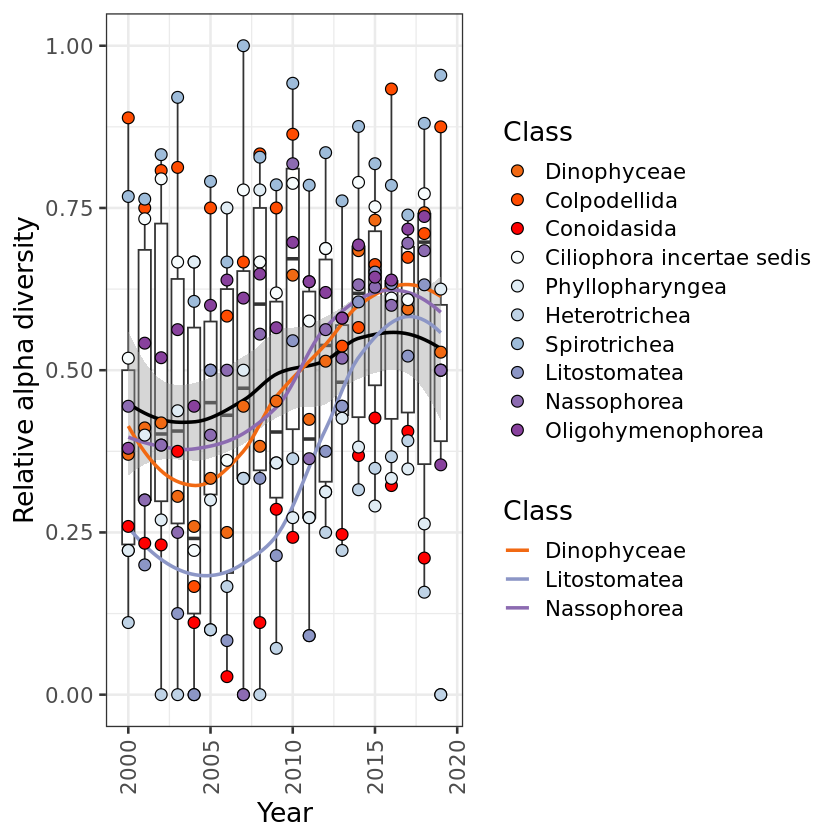

In [21]:
for_plot = for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Class,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Year"),names_from="high_Z",values_from="n")%>%
    replace_na(list(Present=0,Absent=0)) %>%
    dplyr::mutate(RelAlpha=Present/(Present+Absent))
p.vals = sapply(unique(for_plot$Class), function(i) {
  coef(summary(lm(RelAlpha ~ Year, data=for_plot[for_plot$Class==i, ])))[2,4]
})

fits_sig = ggplot(for_plot) + 
    geom_boxplot(aes(x=Year,y=Present/(Present+Absent),
                     group=paste0(Year)))+ 
    geom_smooth(aes(x=Year,y=Present/(Present+Absent)),color="black",
                se=T)+
    geom_smooth(data=for_plot[for_plot$Class %in% names(p.vals)[p.vals < 0.05],],
                aes(x=Year,y=Present/(Present+Absent),color=Class,
                     group=paste0(Class)),se=F)+
    geom_point(aes(x=Year,y=Present/(Present+Absent),fill=Class,
                     group=paste0(Class,Year)),pch=21,size=3)+
    theme_bw(base_size=16)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("Year") +
    ylab("Relative alpha diversity")+ 
    scale_fill_manual(values = alv_cols, 
                      breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black", name = "Class")+ 
    scale_color_manual(values = alv_cols, 
                      breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black", name = "Class")
fits_sig

In [22]:
ggplot(counts_mat %>% dplyr::left_join(total_across_spec) %>%
    dplyr::filter(high_Z=="Present") %>% dplyr::mutate(SimpsonFodder=(n/OverallTotal)^2) %>%
    dplyr::group_by(Year,SampleDate) %>% dplyr::summarize(Simpson=1-sum(SimpsonFodder)) %>%
    dplyr::group_by(Year) %>% dplyr::summarize(meanSimp=mean(Simpson)))+geom_point(aes(x=Year,y=meanSimp))+
    geom_smooth(aes(x=Year,y=meanSimp))

ERROR: Error in dplyr::left_join(., total_across_spec): object 'counts_mat' not found


Joining, by = "Label"


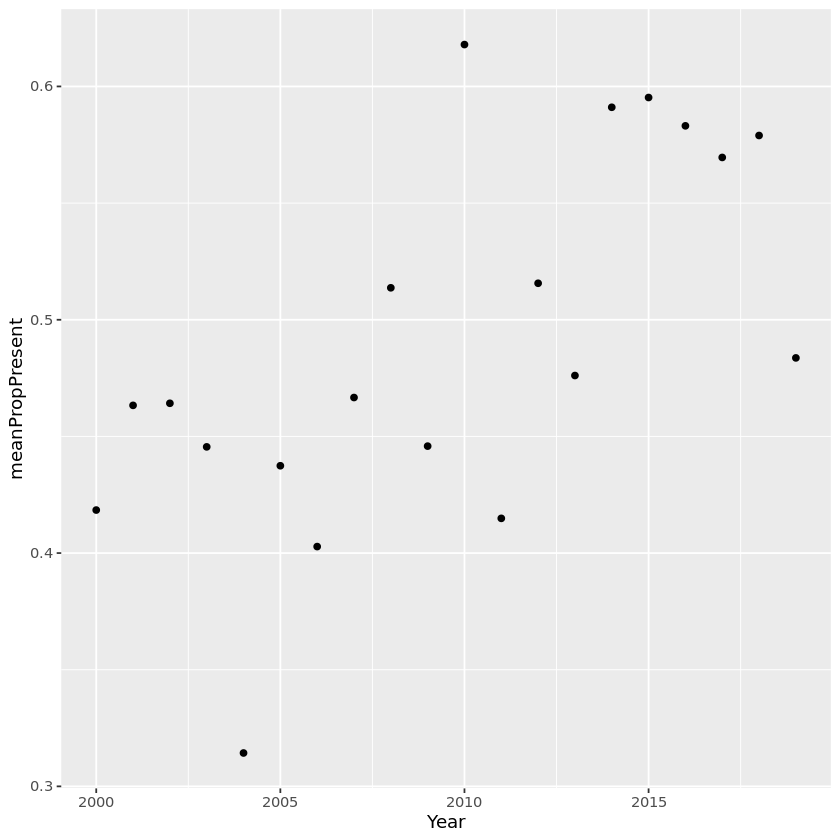

In [29]:
ggplot(for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Class,SampleDate,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Year","SampleDate"),
                       names_from="high_Z",values_from="n")%>%
    replace_na(list(Present=0,Absent=0)) %>%
    dplyr::mutate(PropPresent=Present/(Present+Absent)) %>%
    dplyr::group_by(Year) %>% dplyr::summarize(RangePropPresent = max(PropPresent)-min(PropPresent),
                                               meanPropPresent = mean(PropPresent),
                                               sdPropPresent = sd(PropPresent)))+
    geom_point(aes(x = Year, y = meanPropPresent))

Joining, by = "Label"
Picking joint bandwidth of 0.157

Picking joint bandwidth of 0.158

Picking joint bandwidth of 0.164

Picking joint bandwidth of 0.117

Picking joint bandwidth of 0.31

Picking joint bandwidth of 0.294

Picking joint bandwidth of 0.281

Picking joint bandwidth of 0.0856

Picking joint bandwidth of 0.168

Picking joint bandwidth of 0.118



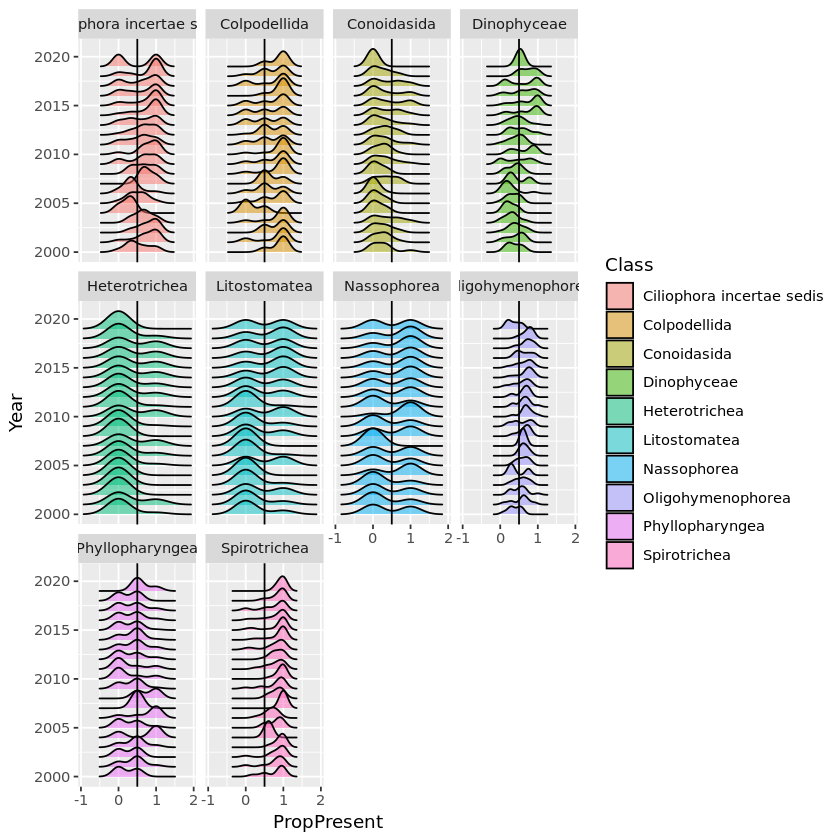

In [122]:
ggplot(for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Class,SampleDate,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Year","SampleDate"),
                       names_from="high_Z",values_from="n")%>%
    replace_na(list(Present=0,Absent=0)) %>%
    dplyr::mutate(PropPresent=Present/(Present+Absent))) + 
    geom_density_ridges(aes(x = PropPresent, y = Year,
                   group=paste0(Class,Year), fill = Class),alpha=0.5) + facet_wrap(~Class) + 
    geom_vline(aes(xintercept=0.5))

Joining, by = "Label"
Joining, by = "Label"
Joining, by =
c("Phylum", "Class",
"Year", "SampleDate")
`summarise()` has
grouped output by
'Year', 'SampleDate'.
You can override using
the `.groups` argument.
Warning message:
“Removed 944 rows
containing non-finite
values
(`stat_boxplot()`).”


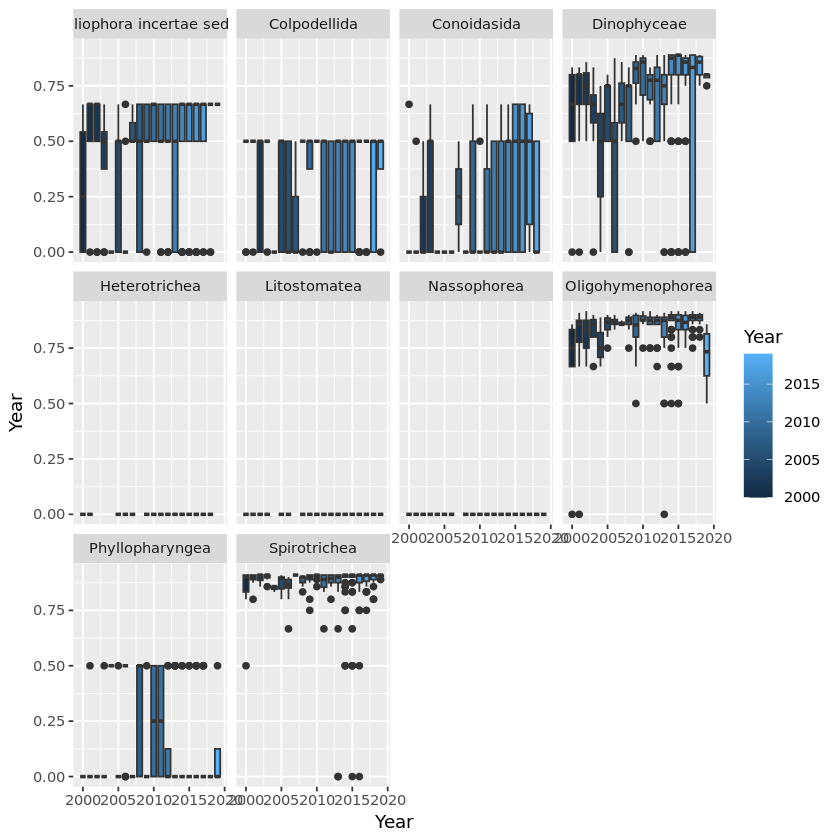

In [24]:
counts_mat = for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Label,Class,SampleDate,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Label","Class","Year","SampleDate"),
                       names_from="high_Z",values_from="n")%>%
    replace_na(list(Present=0,Absent=0)) 

total_across_spec = for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Class,SampleDate,high_Z) %>% dplyr::tally() %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Year","SampleDate"),names_from="high_Z",values_from="n")%>%
    replace_na(list(Present=0,Absent=0)) %>% dplyr::mutate(OverallTotal = Present) %>%
    dplyr::select(-Present,-Absent)
ggplot(counts_mat %>% dplyr::left_join(total_across_spec) %>% 
       dplyr::mutate(SimpsonFodder=(Present/OverallTotal)^2) %>%
    dplyr::group_by(Year,SampleDate,Class) %>% dplyr::summarize(Simpson=1-sum(SimpsonFodder)),
    aes(y = Year))+
    geom_boxplot(aes(x = Year, y = Simpson, fill=Year, group = paste0(Year))) + 
    facet_wrap(~Class)

In [67]:
counts_mat %>% dplyr::left_join(total_across_spec) %>%
    dplyr::filter(high_Z=="Present") %>% dplyr::mutate(SimpsonFodder=(n/OverallTotal)^2) %>%
    dplyr::filter(SimpsonFodder==1)

Joining, by = c("Year",
"Class", "SampleDate")


Phylum,Label,Year,Class,SampleDate,high_Z,n,OverallTotal,SimpsonFodder
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
Dinoflagellata,MEND-TF-18S-134,2000,Dinophyceae,11May2000,Present,1,1,1
Dinoflagellata,MEND-TF-18S-134,2006,Dinophyceae,05Jul2006,Present,1,1,1
Dinoflagellata,MEND-TF-18S-134,2006,Dinophyceae,12Jul2006,Present,1,1,1
Dinoflagellata,MEND-TF-18S-134,2006,Dinophyceae,20Jul2006,Present,1,1,1
Dinoflagellata,MEND-TF-18S-143,2008,Dinophyceae,11Jul2008,Present,1,1,1
Dinoflagellata,MEND-TF-18S-143,2013,Dinophyceae,31May2013,Present,1,1,1
Dinoflagellata,MEND-TF-18S-143,2015,Dinophyceae,04Jun2015,Present,1,1,1
Dinoflagellata,MEND-TF-18S-143,2015,Dinophyceae,16Jun2015,Present,1,1,1
Dinoflagellata,MEND-TF-18S-143,2015,Dinophyceae,27Jun2015,Present,1,1,1


Joining, by = "Label"
Joining, by = "Label"
`summarise()` has
grouped output by
'Year'. You can override
using the `.groups`
argument.
Joining, by = c("Year",
"SampleDate")
`summarise()` has
grouped output by
'Year'. You can override
using the `.groups`
argument.


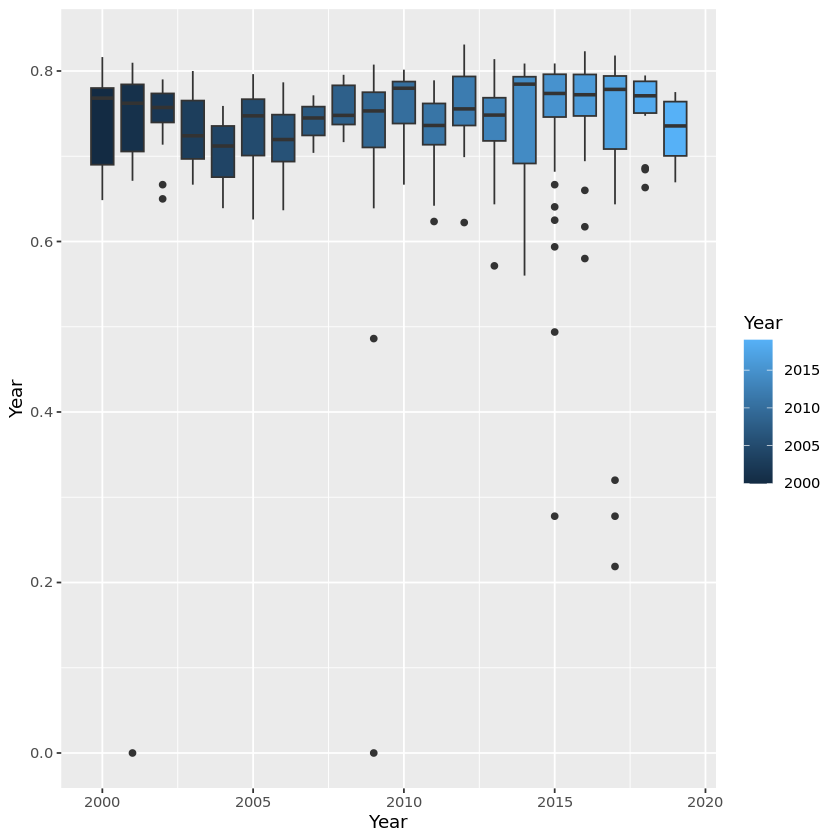

In [120]:
counts_mat = for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Class,SampleDate,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) #%>%
    #tidyr::pivot_wider(id_cols=c("Phylum","Class","Year"),names_from="high_Z",values_from="n")%>%
    #replace_na(list(Present=0,Absent=0)) 

total_across_spec = for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Year,SampleDate,Class,high_Z) %>% dplyr::tally() %>%
    dplyr::filter(high_Z == "Present") %>%
    dplyr::group_by(Year,SampleDate) %>% dplyr::summarize(OverallTotal=sum(n))
ggplot(counts_mat %>% dplyr::left_join(total_across_spec) %>%
    dplyr::filter(high_Z=="Present") %>% dplyr::mutate(SimpsonFodder=(n/OverallTotal)^2) %>%
    dplyr::group_by(Year,SampleDate) %>% dplyr::summarize(Simpson=1-sum(SimpsonFodder)),
    aes(y = Year))+
    geom_boxplot(aes(x = Year, y = Simpson, fill=Year, group = Year))

Joining, by = "Label"
`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'
`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'


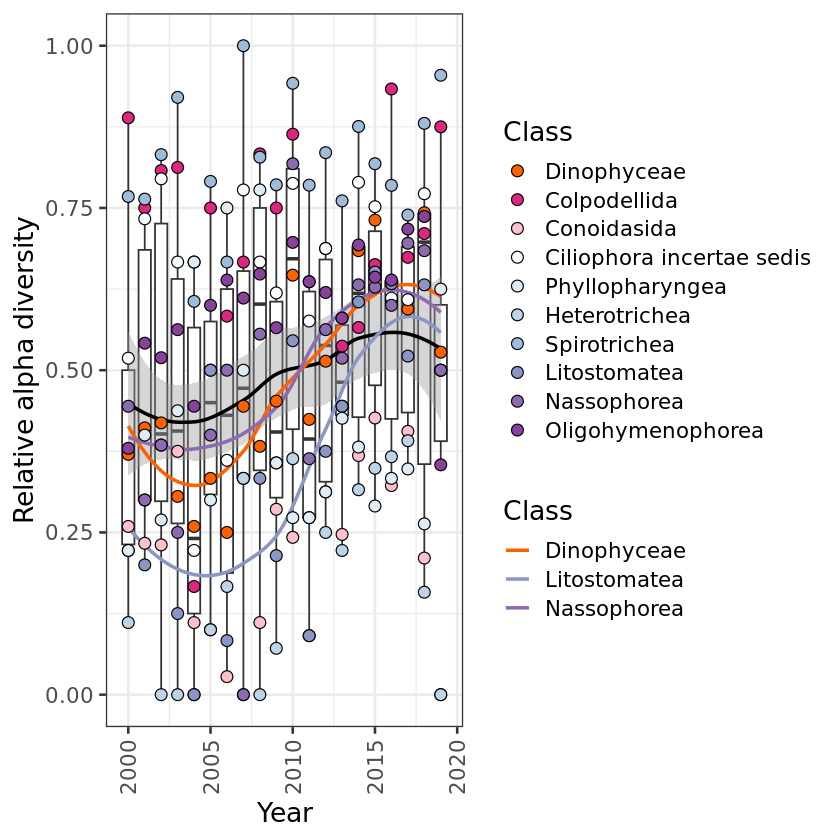

In [33]:
for_plot = for_plotting  %>% dplyr::select(-y) %>%
    dplyr::left_join(data_tree_alv_mod %>% dplyr::select(Label,y)) %>% 
    dplyr::distinct(Phylum,Class,Label,SampleDate,Clade.y,.keep_all=TRUE) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Clade.y","Label","y"),
                       names_from="SampleDate",
                       values_from="TPM") %>%
    tidyr::pivot_longer(cols=!starts_with(c("Phylum","Clade.y","Class","y",
                                            "Label")),names_to="SampleDate",values_to="TPM") %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))%>%
    #replace_na(list(TPM="Missing")) %>%
    dplyr::filter((trimws(Phylum) == "Alveolata") | (trimws(Clade.y) == "Alveolata")) %>%
    dplyr::mutate(high_Z = case_when((!is.na(TPM))&(TPM>0)~"Present",
                                     TRUE ~"Absent")) %>% 
    dplyr::group_by(Phylum,Year,Class,high_Z) %>% dplyr::tally()%>%
    dplyr::mutate(Phylum = dplyr::case_when(Phylum == "Alveolata" ~ "Dinoflagellata",
                                            TRUE ~ Phylum)) %>%
    tidyr::pivot_wider(id_cols=c("Phylum","Class","Year"),names_from="high_Z",values_from="n")%>%
    replace_na(list(Present=0,Absent=0)) %>%
    dplyr::mutate(RelAlpha=Present/(Present+Absent))
p.vals = sapply(unique(for_plot$Class), function(i) {
  coef(summary(lm(RelAlpha ~ Year, data=for_plot[for_plot$Class==i, ])))[2,4]
})

fits_sig = ggplot(for_plot) + 
    geom_boxplot(aes(x=Year,y=Present/(Present+Absent),
                     group=paste0(Year)))+ 
    geom_smooth(aes(x=Year,y=Present/(Present+Absent)),color="black",
                se=T)+
    geom_smooth(data=for_plot[for_plot$Class %in% names(p.vals)[p.vals < 0.05],],
                aes(x=Year,y=Present/(Present+Absent),color=Class,
                     group=paste0(Class)),se=F)+
    geom_point(aes(x=Year,y=Present/(Present+Absent),fill=Class,
                     group=paste0(Class,Year)),pch=21,size=3)+
    theme_bw(base_size=16)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("Year") +
    ylab("Relative alpha diversity")+ 
    scale_fill_manual(values = alv_cols, 
                      breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black", name = "Class")+ 
    scale_color_manual(values = alv_cols, 
                      breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black", name = "Class")
fits_sig

Warning message:
“Removed 30 rows containing
missing values
(`position_stack()`).”
Picking joint bandwidth of 0.102

`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'
`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'
Warning message:
“Removed 30 rows containing
missing values
(`position_stack()`).”
Picking joint bandwidth of 0.102

`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'
`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'
Warning message:
“Removed 30 rows containing
missing values
(`position_stack()`).”
Picking joint bandwidth of 0.102

`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'
`geom_smooth()` using
method = 'loess' and
formula = 'y ~ x'


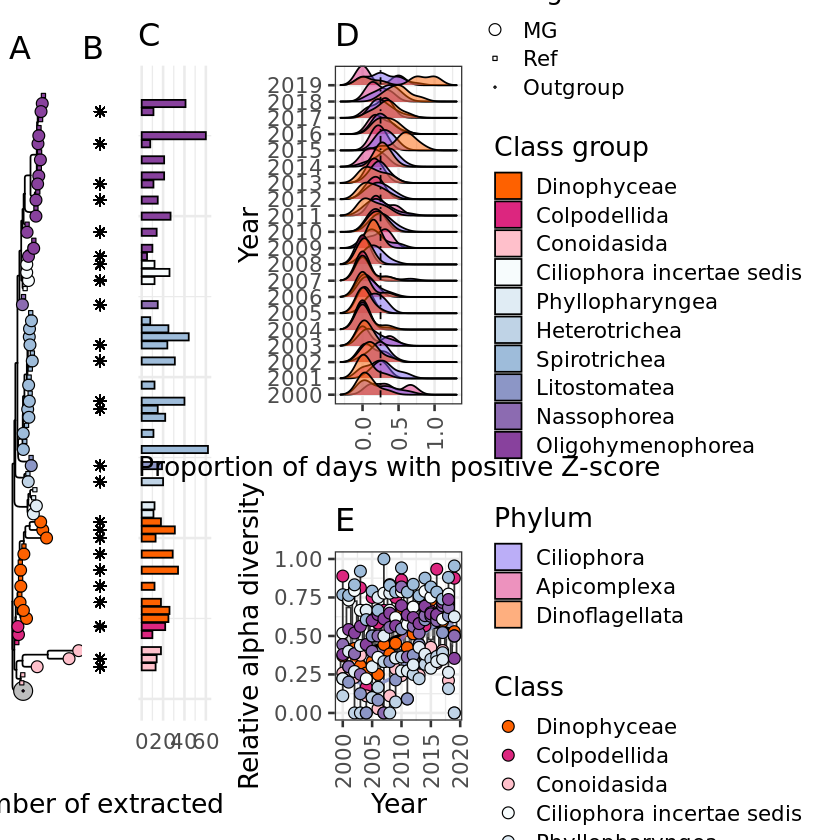

In [276]:
(p1+ggtitle("A")|verdict_plot+ggtitle("B")|(ggplot(barplot_df) + geom_barh(aes(x = val, y = y, 
                                         fill= Class),stat="identity",color="black") + theme_minimal(base_size=16) + 
    scale_fill_manual(values = alv_cols, breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black", name = "Class group") +
    ggtitle("C") + xlab("Number of extracted rRNAs (97%)") + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+ 
    ylim(c(min(data_tree_alv_mod$y),max(data_tree_alv_mod$y))))|(((alv_dist+ggtitle("D"))/
                                                                  (fits_sig+ggtitle("E"))))+plot_layout(heights=c(2,1))) + 
    plot_layout(guides="collect",widths=c(1,0.5,1,1.75))

ggsave("../../figures/alveolate_panel_rev.png",height=12,width=18,units="in",dpi=400)
ggsave("../../figures/alveolate_panel_rev.pdf",height=12,width=18,units="in",dpi=400)

Picking joint bandwidth of 0.102



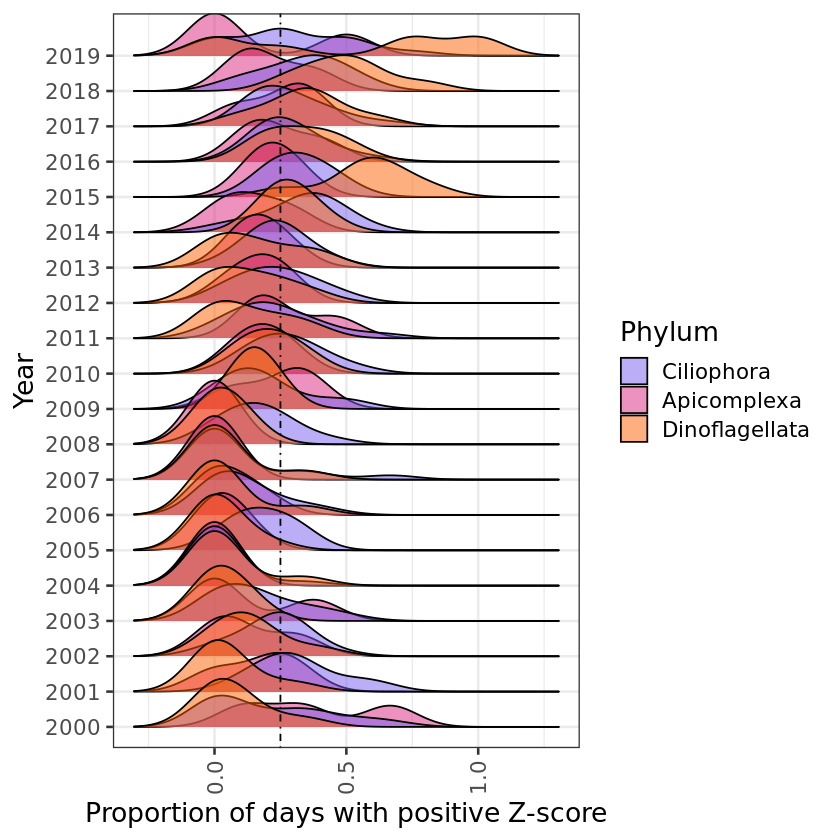

In [186]:
alv_dist

Warning message:
“Removed 30 rows containing
missing values
(`position_stack()`).”
Picking joint bandwidth of 0.102



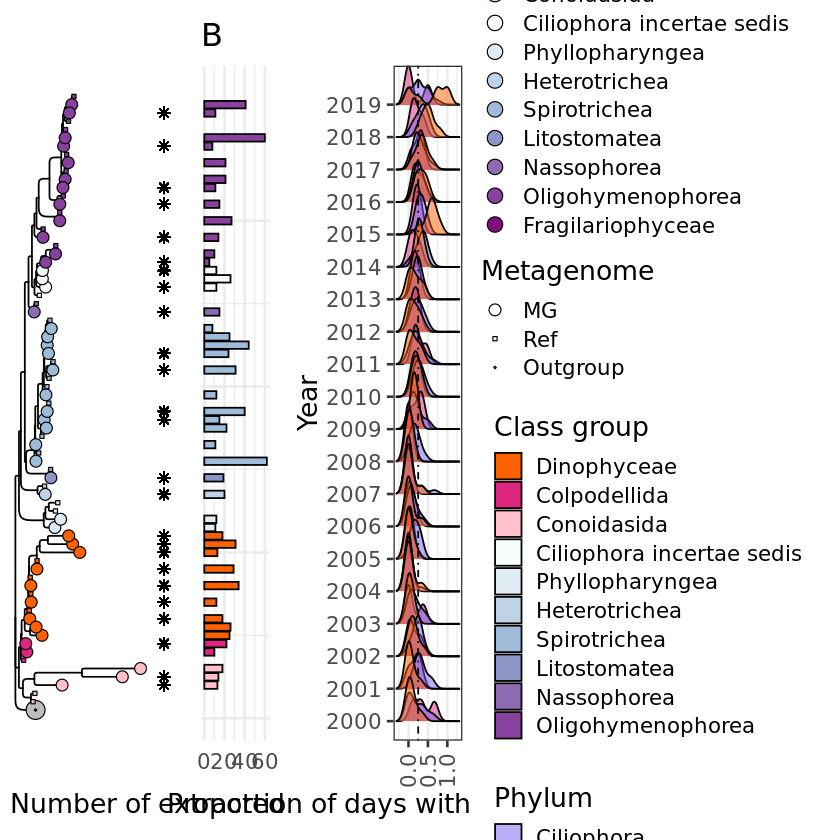

In [187]:
(p1|verdict_plot|(ggplot(barplot_df) + geom_barh(aes(x = val, y = y, 
                                         fill= Class),stat="identity",color="black") + theme_minimal(base_size=16) + 
    scale_fill_manual(values = alv_cols, breaks=na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       labels = na.omit(unique((data_tree_alv_mod%>%dplyr::arrange(Phylum))$Class)),
                       na.value="black", name = "Class group") +
    ggtitle("B") + xlab("Number of extracted rRNAs (97%)") + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+ 
    ylim(c(min(data_tree_alv_mod$y),max(data_tree_alv_mod$y))))|alv_dist) + 
    plot_layout(guides="collect",widths=c(2,0.5,1,1))

In [177]:
patchwork_phylo = ((p1 + guides(fill="none", color="none")) + ggtitle("A")) + 
    (ggplot(barplot_df) + geom_barh(aes(x = val, y = y, 
                                         fill= Class),stat="identity") + theme_minimal(base_size=16) + 
    scale_fill_manual(values = distinct_cols, breaks=na.omit(unique(data_tree_alv_mod$Class)),
                       labels = na.omit(unique(data_tree_alv_mod$Class)),
                       na.value="black", name = "Class group") +
    ggtitle("B") + xlab("Number of extracted rRNAs (97%)") + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()))+
    plot_layout(guides = 'collect',widths=c(2,1))

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_tile).”
Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_tile).”


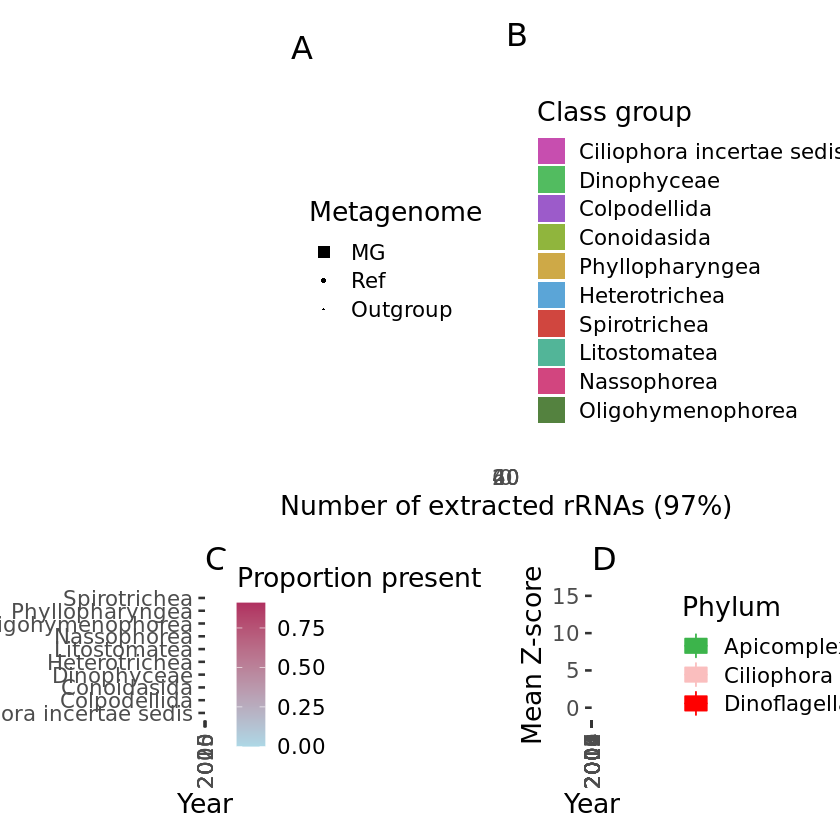

In [47]:
(patchwork_phylo / ((alveolate_heatmap+ggtitle("C"))  | (alveolate_boxplot+ggtitle("D")))) + 
  plot_layout(heights = c(3, 1)) & plot_layout(guides="collect")
ggsave("../../figures/alveolate_panel.png",height=12,width=18,units="in",dpi=400)

Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_tile).”
Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_tile).”
Warning message:
“Removed 30 rows containing missing values (position_stack).”
Warning message:
“Removed 10 rows containing missing values (geom_tile).”


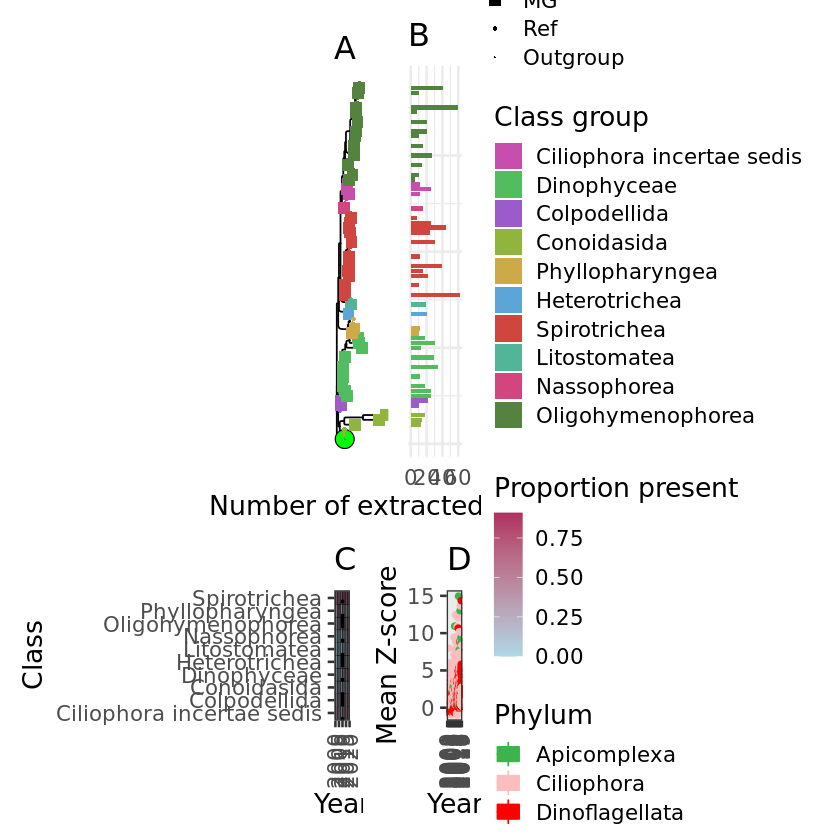

In [78]:
((p1 + guides(fill="none", color="none")) + ggtitle("A") | 
    (ggplot(barplot_df) + aplot::ylim2(p1) + geom_barh(aes(x = val, y = y, 
                                         fill= Class),stat="identity") + theme_minimal(base_size=16) + 
    scale_fill_manual(values = distinct_cols, breaks=na.omit(unique(data_tree_alv_mod$Class)),
                       labels = na.omit(unique(data_tree_alv_mod$Class)),
                       na.value="black", name = "Class group") +
    ggtitle("B") + xlab("Number of extracted rRNAs (97%)") + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()))) / ((alveolate_heatmap+ggtitle("C"))  | (alveolate_boxplot+ggtitle("D"))) + 
  plot_layout(heights = c(3, 1),guides="collect")
ggsave("../../figures/alveolate_panel.png",height=13,width=15,units="in",dpi=400)
ggsave("../../figures/alveolate_panel.pdf",height=13,width=15,units="in",dpi=400)

Warning message in as_grob.default(plot):
“Cannot convert object of class aplot into a grob.”
Warning message:
“Removed 10 rows containing missing values (geom_tile).”


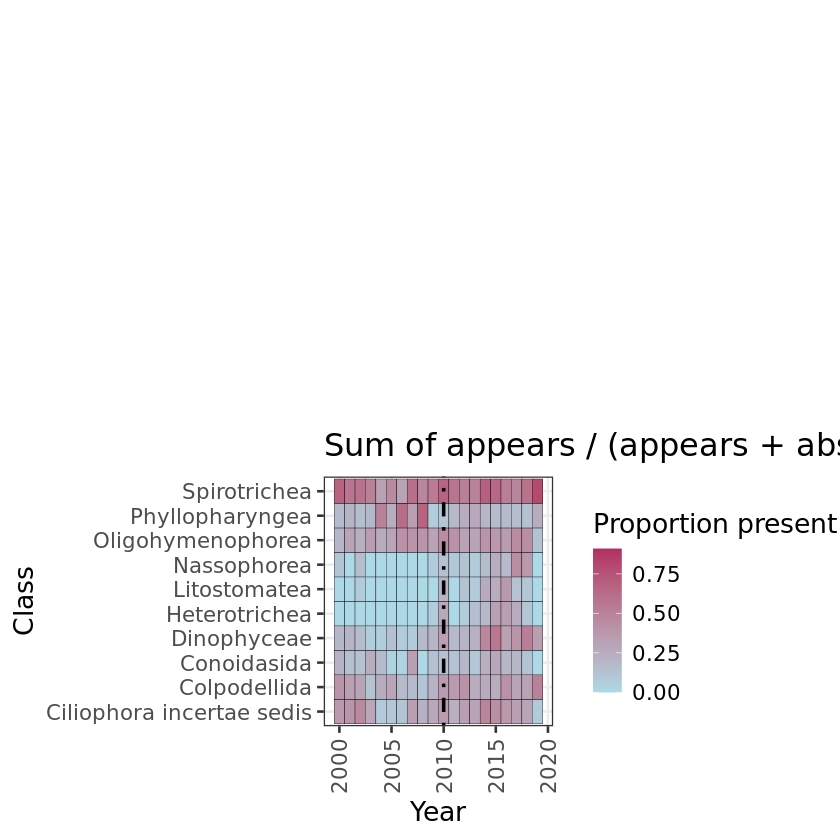

In [71]:
cowplot::plot_grid((((p1 + guides(fill="none", color="none"))) %>% 
    aplot::insert_right(ggplot(barplot_df) + geom_barh(aes(x = val, y = y, 
                                         fill= Class),stat="identity") + theme_minimal(base_size=16) + 
    scale_fill_manual(values = distinct_cols, breaks=na.omit(unique(data_tree_alv_mod$Class)),
                       labels = na.omit(unique(data_tree_alv_mod$Class)),
                       na.value="black", name = "Class group") +
    xlab("Number of extracted rRNAs (97%)") + theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()))),alveolate_heatmap,nrow=2)